# Load required libraries

In [1]:
# data processing and statistics
import pandas as pd
import numpy as np
import spacy
from scipy.stats import randint, uniform
from collections import Counter

# useful functions
from utils import *

# baseline classificator
from sklearn.linear_model import LogisticRegression

# hyperparameters selection and evaluation metrics
from sklearn.metrics import balanced_accuracy_score, f1_score, jaccard_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split

# lbrary for spellchecker model
from spellchecker import SpellChecker
import re

# Keras for Recurrent Network model
from keras.layers import Dense, Input, Lambda, Dropout, Activation, GRU, Bidirectional
from keras.models import Model
from keras.layers.embeddings import Embedding
#from keras.preprocessing import sequence
#from keras.initializers import glorot_uniform
from keras.initializers import Constant
from keras.utils.vis_utils import plot_model
import keras

import pyodbc

np.random.seed(1)
#!python -m spacy download es_core_news_md
nlp = spacy.load('es_core_news_md')
nlp.remove_pipe('lemmatizer')
nlp.remove_pipe('ner')
nlp.remove_pipe('attribute_ruler')

n_classes = 2

# Read and clean input data

In [2]:
# connection parameters
server = '' 
database = '' 
username = 'admin_usersql' 
password = 'admin_usersql'

cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
#cursor = cnxn.cursor()

#Sample select query
query = "SELECT * FROM dbo.EntrenamientoSECOP"
df = pd.read_sql(query,cnxn)

# Erase rows with null values
df = df.loc[~df['ObjetoProceso'].isnull()]

# Erase rows where text length is less than 20
df = df.loc[df['ObjetoProceso'].apply(len) > 20]

# Separate label column and make lower case all text
text = df['ObjetoProceso']
#text = np.array([text.lower() for text in text])

# Spell checker and in-context correction
text_all_corrected = correct_words(text)
print(len(text_all_corrected))

y = df['Clasificacion'].astype(int)
Counter(y)

6081


Counter({1: 5047, 0: 1034})

## -Bidirectional Recurrent Neural Net with GRU cell and secuetial word embeddings

In [3]:
# Split dataset into train and test sets of documents
text_train, text_test, y_train, y_test = train_test_split(text_all_corrected, y.values, test_size=.2, random_state=42)

In [4]:
# 
maxLen = max([len(text.split(' ')) for text in text_train])
tokens = {word for sentence in text_all_corrected for word in sentence.split(' ')} - {''}
vocab = sorted(list(tokens))
np.savetxt('dict/vocab.txt', vocab, fmt='%s', delimiter=',')

In [ ]:
#np.savetxt('dict/vocab2_1.txt', vocab, fmt='%s', delimiter=',')

In [5]:
# Generate the word embedding matrix
num_tokens = len(vocab)
embedding_dim = len(nlp('ola').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(word).vector

In [6]:
X_train_indices = sentences_to_indices(text_train, vocab, maxLen)
#y_train_oh = convert_to_one_hot(y_train, n_classes)

X_test_indices = sentences_to_indices(text_test, vocab, maxLen)
#y_test_oh = convert_to_one_hot(y_test, n_classes)

In [7]:
classes = dict(Counter(y_train))
pos = classes[1]
neg = classes[0]
# initial_bias = np.log([pos/neg])
# initial_bias

In [8]:
#maxLen = 194
model = TextClassification(maxLen,embedding_matrix, n_classes, num_tokens, embedding_dim)
model.summary()

2022-01-20 11:48:26.241043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 11:48:26.241466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 11:48:26.241742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 11:48:26.242152: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 194)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 194, 300)          1715100   
_________________________________________________________________
bidirectional (Bidirectional (None, 194, 256)          330240    
_________________________________________________________________
dropout (Dropout)            (None, 194, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257   

In [9]:
metrics = [
    'accuracy', 'Recall', 'Precision',
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR')
      ]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)

In [28]:
# X_train[216] # texto cortado

In [10]:
total = len(y_train)
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 2.9230769230769234, 1: 0.6031746031746031}

In [11]:
#Train model
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_recall', 
    patience=5,
    mode='max',
    restore_best_weights=True
    )

# Split dataset into train and test sets of documents
X_train_indices, X_val_indices, y_train, y_val = train_test_split(X_train_indices, y_train, test_size=.1, random_state=42)

model.fit(X_train_indices, y_train, batch_size=128, epochs=100, validation_data = (X_val_indices, y_val), 
    callbacks = [early_stop], class_weight=class_weight)

# model.fit(X_train_indices, y_train, batch_size=128, epochs=100, validation_data = (X_val_indices, y_val), 
#     callbacks = [early_stop])

2022-01-20 11:56:53.671180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
35/35 [==============================] - 39s 874ms/step - loss: 0.2614 - accuracy: 0.8881 - recall: 0.8899 - precision: 0.9725 - auc: 0.9588 - prc: 0.9897 - val_loss: 0.1641 - val_accuracy: 0.9405 - val_recall: 0.9315 - val_precision: 0.9974 - val_auc: 0.9939 - val_prc: 0.9987
Epoch 2/100
35/35 [==============================] - 29s 843ms/step - loss: 0.0786 - accuracy: 0.9751 - recall: 0.9757 - precision: 0.9941 - auc: 0.9955 - prc: 0.9990 - val_loss: 0.0413 - val_accuracy: 0.9856 - val_recall: 0.9878 - val_precision: 0.9951 - val_auc: 0.9977 - val_prc: 0.9995
Epoch 3/100
35/35 [==============================] - 30s 856ms/step - loss: 0.0395 - accuracy: 0.9888 - recall: 0.9887 - precision: 0.9978 - auc: 0.9984 - prc: 0.9997 - val_loss: 0.0318 - val_accuracy: 0.9897 - val_recall: 0.9951 - val_precision: 0.9927 - val_auc: 0.9982 - val_prc: 0.9996
Epoch 4/100
35/35 [==============================] - 32s 915ms/step - loss: 0.0244 - accuracy: 0.9936 - recall: 0.9937 - precision

In [12]:
# model.save('models/bigru_model_v2.h5')

In [ ]:
# model = keras.models.load_model('models/bigru_model_v3.h5')
# model.summary()

In [111]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) 

In [17]:
index_to_word = dict()
for index, word in enumerate(vocab):
    index_to_word[index] = word 

len(index_to_word)

6052

In [15]:
loss, acc, tpr, ppv, auc, prc  = model.evaluate(X_test_indices, y_test)
# loss, acc, auc,  = model.evaluate(X_test_indices, y_test_oh)
print("Test accuracy = ", acc)
print("Test auc-roc = ", auc)
print("Test auc-prc = ", prc)
print("Test true possitive rate = ",tpr)
print("Test Precision = ",ppv)

from sklearn.metrics import balanced_accuracy_score, f1_score, jaccard_score

uncertainty_model = False
if uncertainty_model:
    rg = [.3, .7]
    h_test = -1*np.ones((len(y_test),1))
    pos = model.predict(X_test_indices) >= rg[1]
    h_test[pos] = 1
    neg = model.predict(X_test_indices) <= rg[0]
    h_test[neg] = 0
    print(f"in-confiden-interval labeled samples: {(len(h_test[pos]) + len(h_test[neg]))/len(y_test)}")
    print(f"Not labeled samples: {-len(h_test[pos]) - len(h_test[neg]) + len(y_test)}")

    no_label_idx = np.where(h_test[:,0] == -1)[0]
    for idx in no_label_idx:
        x = np.array(X_test_indices[idx,:])[np.newaxis, :, np.newaxis]
        est = model.predict(x)
        #pred = np.argmax(est)
        pred = int(est[0,0] > .5)
        sentence = ''
        word_idx_old = -1
        for word_idx in x[0,:,0]:
            if word_idx == word_idx_old:
                continue
            word_idx_old = word_idx
            sentence += index_to_word[word_idx] + ' '
        print(sentence[:-2])
        print('Expected label:'+ str(y_test[idx]) + ' prediction: '+ str(pred) + ' ' + str(est[0,0]))
        
    y_test = y_test[:,np.newaxis]
    y_test = y_test[pos + neg]
    h_test = h_test[pos + neg]
else:
    th = .5
    h_test = (model.predict(X_test_indices) > th).astype(int)
    # h_test = np.argmax(model.predict(X_test_indices), axis=1)


39/39 [==============================] - 5s 126ms/step - loss: 0.0567 - accuracy: 0.9852 - recall: 0.9970 - precision: 0.9854 - auc: 0.9913 - prc: 0.9968
Test accuracy =  0.9852095246315002
Test auc-roc =  0.991330623626709
Test auc-prc =  0.9967960715293884
Test true possitive rate =  0.9970443248748779
Test Precision =  0.9853943586349487


In [16]:
print(f'Balanced test acc: {balanced_accuracy_score(y_test, h_test)}')
print(f'Test f1-score: {f1_score(y_test, h_test, average = "micro" )}')
print(f'Test jaccard-score: {jaccard_score(y_test, h_test)}')

Balanced test acc: 0.9613934546163976
Test f1-score: 0.9852095316351684
Test jaccard-score: 0.9825242718446602


In [ ]:

for i, x in enumerate(X_test_indices):
    x = np.array(x)[np.newaxis, :, np.newaxis]
    est = model.predict(x)
    #pred = np.argmax(est)
    pred = int(est[0,0] > .5)
    if pred != y_test[i]:
        sentence = ''
        idx_old = -1
        for idx in x[0,:,0]:
            if idx == idx_old:
                continue
            idx_old = idx
            sentence += index_to_word[idx] + ' '
        print(sentence[:-2])
        print('Expected label:'+ str(y_test[i]) + ' prediction: '+ str(pred) + ' ' + str(est[0,0]))

Matriz de confusión para el conjunto de testeo


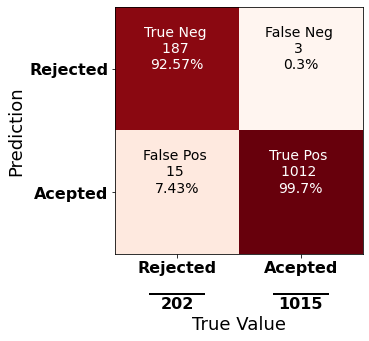

In [17]:
from sklearn.metrics import confusion_matrix

class_names = np.array(['Rejected', 'Acepted'])

print("Matriz de confusión para el conjunto de testeo")
# Compute Testing confusion matrix
cnf_matrix = confusion_matrix(h_test, y_test)
#np.set_printoptions(precision=2)
# Plot matriz de confusion sin normalizar
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de confusion')